# process spectra for AuxTel with new spectractor (September 2021): Part 1 guess (x,y) of order 0

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : October 14th 2021

- version v4 : Work with new exposure format quickLookExp_v2


This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Scan

    # wide scan : HD 160617 
    # all_myseq_holo=range(234,310)
    # narrow scan :  HD 160617 
    # all_myseq_holo=range(317,365)


# Imports

In [70]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [71]:
from iminuit import Minuit
import iminuit

In [72]:
iminuit.__version__

'2.7.0'

In [73]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [74]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [75]:
from distutils.dir_util import copy_tree

# Configuration

In [76]:
version="v4.0"  # version of flipping
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True

FLAG_REMOVE_WCS=False

# Path

In [77]:
# path index for each month
DATE="2021-07-07"
DATE2="2021_07_07"

In [78]:
# select if we run at CC or not (locally) 
HOSTCC=False

In [79]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2021/holo/OutputSpectractor/"+DATE)
    
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)

# Utility Functions

In [80]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [81]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

In [82]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [83]:
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_' + version+'.csv'

In [84]:
df=pd.read_csv(filename_logbook,index_col=0)

In [85]:
pd.set_option('display.max_rows', None)

In [86]:
# show the list of input files from the logbook to select the file index in the logbook
df

index                     date  \
0        0  2021-07-08T02:50:31.569   
1        1  2021-07-08T02:51:12.101   
2        2  2021-07-08T02:51:21.256   
3        3  2021-07-08T02:51:30.934   
4        4  2021-07-08T02:51:40.885   
5        5  2021-07-08T02:51:50.381   
6        6  2021-07-08T02:51:59.759   
7        7  2021-07-08T02:52:10.113   
8        8  2021-07-08T02:52:19.262   
9        9  2021-07-08T02:52:29.022   
10      10  2021-07-08T03:09:18.381   
11      11  2021-07-08T03:09:51.483   
12      12  2021-07-08T03:10:22.899   
13      13  2021-07-08T03:10:54.635   
14      14  2021-07-08T03:14:25.113   
15      15  2021-07-08T03:18:49.728   
16      16  2021-07-08T03:22:35.058   
17      17  2021-07-08T03:27:28.637   
18      18  2021-07-08T03:31:49.398   
19      19  2021-07-08T03:33:02.383   
20      20  2021-07-08T03:33:40.416   
21      21  2021-07-08T03:34:18.506   
22      22  2021-07-08T03:34:56.504   
23      23  2021-07-08T03:35:34.622   
24      24  2021-07-08T03:36:12.773   
25      25  2021-07-08T03:36:51.324   
26      26  2021-07-08T03:37:29.434   
27      27  2021-07-08T03:38:07.561   
28      28  2021-07-08T03:38:45.707   
29      29  2021-07-08T03:39:23.969   
30      30  2021-07-08T03:40:02.136   
31      31  2021-07-08T03:40:40.864   
32      32  2021-07-08T03:41:19.059   
33      33  2021-07-08T03:41:57.407   
34      34  2021-07-08T03:42:35.608   
35      35  2021-07-08T03:43:13.804   
36      36  2021-07-08T03:43:52.018   
37      37  2021-07-08T03:44:30.763   
38      38  2021-07-08T03:45:08.962   
39      39  2021-07-08T03:45:47.206   
40      40  2021-07-08T03:46:25.307   
41      41  2021-07-08T03:47:03.492   
42      42  2021-07-08T03:47:41.807   
43      43  2021-07-08T03:48:20.795   
44      44  2021-07-08T03:48:58.912   
45      45  2021-07-08T03:49:37.128   
46      46  2021-07-08T03:50:15.298   
47      47  2021-07-08T03:50:53.476   
48      48  2021-07-08T03:51:31.752   
49      49  2021-07-08T03:52:10.906   
50      50  2021-07-08T03:52:49.130   
51      51  2021-07-08T03:53:27.487   
52      52  2021-07-08T03:54:05.770   
53      53  2021-07-08T03:54:44.149   
54      54  2021-07-08T03:55:22.356   
55      55  2021-07-08T03:57:27.244   
56      56  2021-07-08T04:01:50.450   
57      57  2021-07-08T04:04:12.555   
58      58  2021-07-08T04:05:06.367   
59      59  2021-07-08T04:05:38.880   
60      60  2021-07-08T04:06:11.311   
61      61  2021-07-08T04:06:43.769   
62      62  2021-07-08T04:07:16.223   
63      63  2021-07-08T04:07:48.665   
64      64  2021-07-08T04:08:21.107   
65      65  2021-07-08T04:08:54.078   
66      66  2021-07-08T04:09:26.572   
67      67  2021-07-08T04:09:59.052   
68      68  2021-07-08T04:10:31.515   
69      69  2021-07-08T04:11:03.986   
70      70  2021-07-08T04:11:36.404   
71      71  2021-07-08T04:12:08.868   
72      72  2021-07-08T04:22:19.093   
73      73  2021-07-08T04:22:52.079   
74      74  2021-07-08T04:23:23.868   
75      75  2021-07-08T04:27:28.703   
76      76  2021-07-08T04:49:32.013   
77      77  2021-07-08T04:50:04.270   
78      78  2021-07-08T04:50:36.514   
79      79  2021-07-08T04:51:08.758   
80      80  2021-07-08T04:51:41.005   
81      81  2021-07-08T04:52:13.265   
82      82  2021-07-08T04:52:45.515   
83      83  2021-07-08T04:53:18.264   
84      84  2021-07-08T04:53:50.521   
85      85  2021-07-08T04:54:22.770   
86      86  2021-07-08T04:54:55.016   
87      87  2021-07-08T04:55:27.314   
88      88  2021-07-08T04:55:59.559   
89      89  2021-07-08T04:56:31.807   
90      90  2021-07-08T04:57:04.543   
91      91  2021-07-08T04:57:36.808   
92      92  2021-07-08T04:58:09.080   
93      93  2021-07-08T04:58:41.316   
94      94  2021-07-08T04:59:13.646   
95      95  2021-07-08T04:59:45.917   
96      96  2021-07-08T05:00:18.159   
97      97  2021-07-08T05:00:50.866   
98      98  2021-07-08T05:01:23.102   
99      99  2021-07-08T05:01:55.386   
100    100  2021-07-08T05:02:27.623   
101    101  2021-07-08T05:0

# Selection of input file
- the input file is selected from the logbook list above

In [87]:
# wide scan : HD 160617 
# all_myseq_holo=range(234,310)

# narrow scan :  HD 160617 
# all_myseq_holo=range(317,365)

In [88]:
#idx=76
#idx=96
#idx=76 # start of narrow scan

idx= 5

#idx=111 # failed too close from border
#idx=112 # failed too close from border
#idx=113 # failed too close from border
#idx=114 # failed too close from border
#idx=115 # failed too close from border
#idx=116 # failed too close from border
#idx=117 # failed too close from border
#idx=118 # failed too close from border
#idx=119 # failed too close from border
#idx=120 # failed too close from border
#idx=121 # failed too close from border
#idx=122 # failed too close from border
#idx=123 # failed too close from border

In [89]:
print(df.iloc[idx]['file'])

holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits


In [90]:
print(df.iloc[idx])

index                                                          5
date                                     2021-07-08T02:51:50.381
path           /Users/dagoret/DATA/AuxTelData2021/holo/quickL...
file           holo4_003_RG610_HD160617_20210707_000239_quick...
num                                                          239
object                                                  HD160617
filter                                                     RG610
disperser                                              holo4_003
airmass                                                 1.021763
exposure                                                     5.0
focus                                                  -1.588317
seeing                                                       NaN
pressure                                                  742.45
temperature                                                 12.1
humidity                                                     6.0
windspd                  

In [91]:
myhome=os.getenv("HOME")

In [92]:
dir_images=path_images

In [93]:
filename_image=df['file'][idx]
filename_image

'holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits'

In [94]:
file_target(filename_image)

'HD160617'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [95]:
x0=df['Obj-posXpix'][idx]
y0=df['Obj-posYpix'][idx]

In [96]:
FLAG_ORDER0_LOCATION=False

In [97]:
if not is_nan(x0)and not is_nan(y0):
    FLAG_ORDER0_LOCATION=True
    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

Order 0 location from logbook : (600.0,1900.0)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [98]:
filename_image.split(".")[0]

'holo4_003_RG610_HD160617_20210707_000239_quickLookExp'

In [99]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07'

In [100]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
subdir=filename_image.split(".")[0]

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)

# local directories to put spectra and plots
output_directory="./outputs_process_holo_scan"
output_figures="figures_process_holo_scan"

# Final output directory


guess = [250,2600]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)

# configuration

# standard spectractor init configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

target = file_target(filename_image)[0]

In [101]:
finalpath_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_RG610_HD160617_20210707_000239_quickLookExp'

### manage output dir

In [102]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                os.remove(os.path.join(path,f))

In [103]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    if not os.path.isdir(output_directory):
        os.mkdir(output_directory)
    else:
        cleandir(output_directory)
 
    # manage subdirs spectrum/ and plots/
    if not os.path.isdir(output_figures):
        os.mkdir(output_figures)
    else:
        cleandir(output_figures)
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        #cleandir(finalpath_output_spectractor)
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

# Configuration of the Spectractor running mode

In [104]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

## Load the image in the new image file with Spectractor

In [105]:
image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: False	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: False	 <class 'bool'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> par

2021-10-14 23:16:51  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07/holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits...
2021-10-14 23:16:51  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-10-14 23:16:51  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-10-14 23:16:51  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-10-14 23:16:51  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2021-10-14 23:16:56  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.408676604984107 but average of self.read_out_noise is 8.5.
2021-10-14 23:16:56  TelescopeTransmission reset_lambd

## Show relevant parameters

In [106]:
parameters.OBS_NAME

'AUXTEL'

In [107]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [108]:
parameters.DISTANCE2CCD

182.0

In [109]:
parameters.LAMBDA_MIN 

563

In [110]:
parameters.LAMBDA_MAX 

1095

In [111]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [112]:
image.filter_label

'RG610'

In [113]:
image.header["FILTER"]

'RG610'

In [114]:
#image.header

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

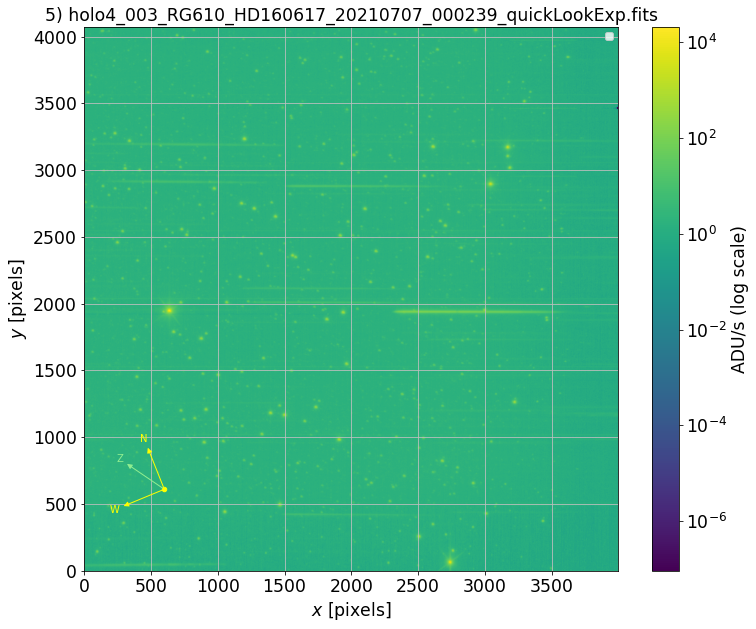

In [115]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [116]:
filename_image

'holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits'

In [117]:
# overwrite if localtion is taken from that in logbook
if FLAG_ORDER0_LOCATION : 
    print("Set Order 0 location from logbook : ({},{})".format(x0,y0))
    guess = [x0,y0]

Set Order 0 location from logbook : (600.0,1900.0)


## Let Spectractor find the location of the 0th order

2021-10-14 23:17:03  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
            c0_0                c1_0                 c0_1        
    ------------------- -------------------- --------------------
    -0.6737273139964725 0.022566525660572465 0.022828046786877134
2021-10-14 23:17:03  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 7 iterations because the relative change of cost is below ftol=1.25e-05.


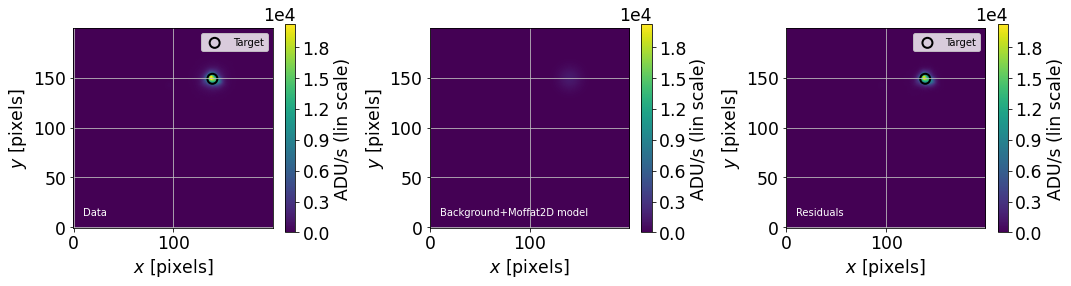

2021-10-14 23:17:04  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-06.


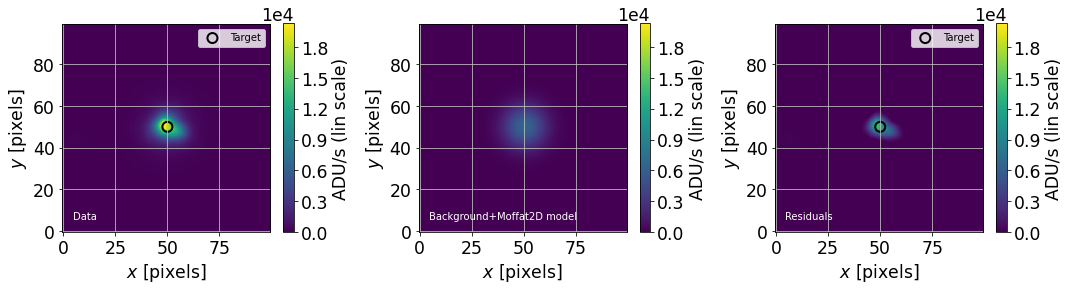

2021-10-14 23:17:05  Image      find_target          INFO   
	X,Y target position in pixels: 639.051,1948.933


In [118]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [119]:
print(x1,y1)

639.0511160603762 1948.9334748726012


## Check the location of 0th order and Analysis of the quality of its focus

In [120]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [121]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [122]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [123]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [124]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [125]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [126]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [127]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [128]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [129]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [130]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [131]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [132]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

<ipython-input-133-9da0d4ef5b3f>:32: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle(title,Y=1.01)


Text(0.5, 1.01, '5) holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits')

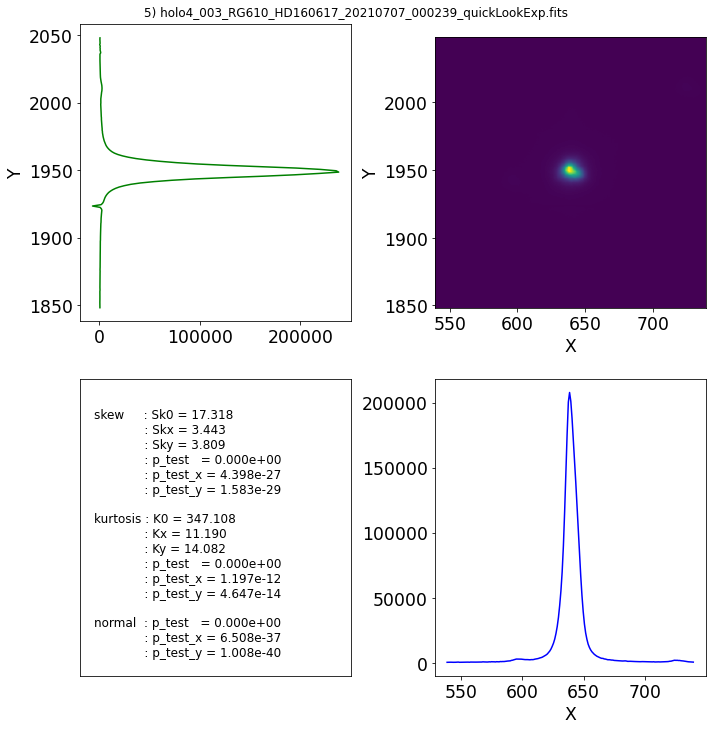

In [133]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title,Y=1.01)

In [134]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [135]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

2021-10-14 23:17:06  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: False	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: False	 <class 'bool'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> par

2021-10-14 23:17:06  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07/holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits...
2021-10-14 23:17:06  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-10-14 23:17:06  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-10-14 23:17:06  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-10-14 23:17:06  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2021-10-14 23:17:11  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.408676604984107 but average of self.read_out_noise is 8.5.
2021-10-14 23:17:11  TelescopeTransmission reset_lambd

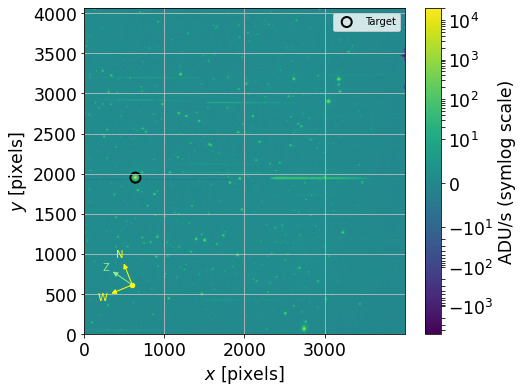

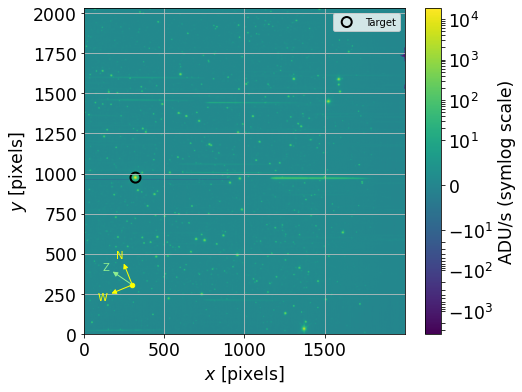

2021-10-14 23:17:18  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[319.52555803 974.46673744]...
2021-10-14 23:17:18  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0                 c0_1       
    ----------------- -------------------- -------------------
    2.949533585191622 0.006158871141110913 0.00888289306170406
2021-10-14 23:17:18  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=5e-05.


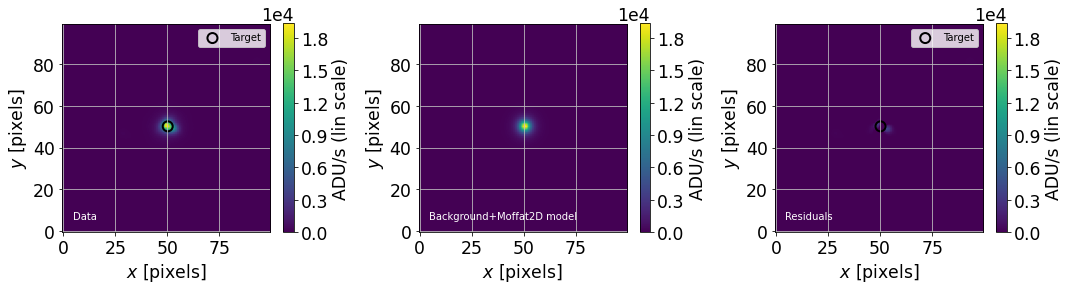

2021-10-14 23:17:19  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=0.0002.


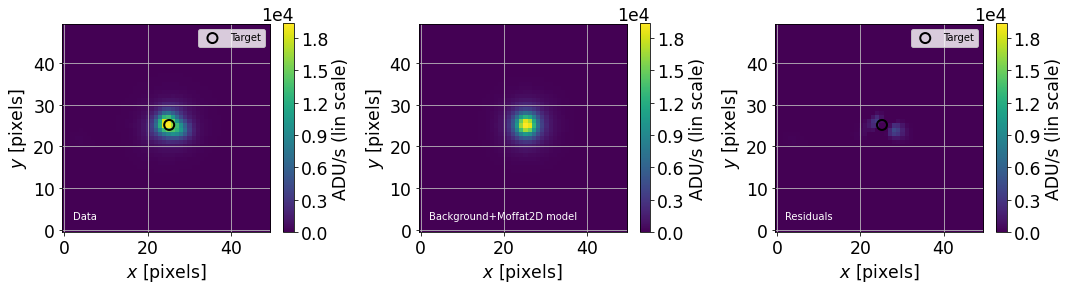

2021-10-14 23:17:20  Image      find_target          INFO   
	X,Y target position in pixels: 319.201,974.172
2021-10-14 23:17:20  Image      turn_image           INFO   
	Rotate the image with angle theta=0.00 degree


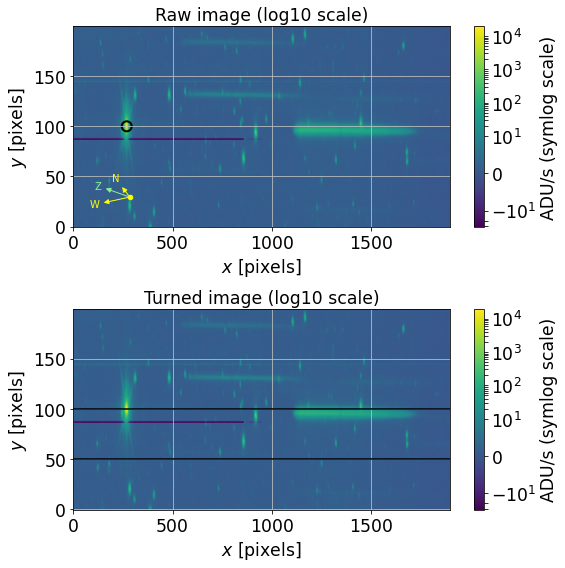

2021-10-14 23:17:24  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-10-14 23:17:24  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                 c1_0                c0_1       
    ------------------ --------------------- ------------------
    12.837611527263808 -0.007829766563516456 0.1576792860927893
2021-10-14 23:17:24  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=0.0002.


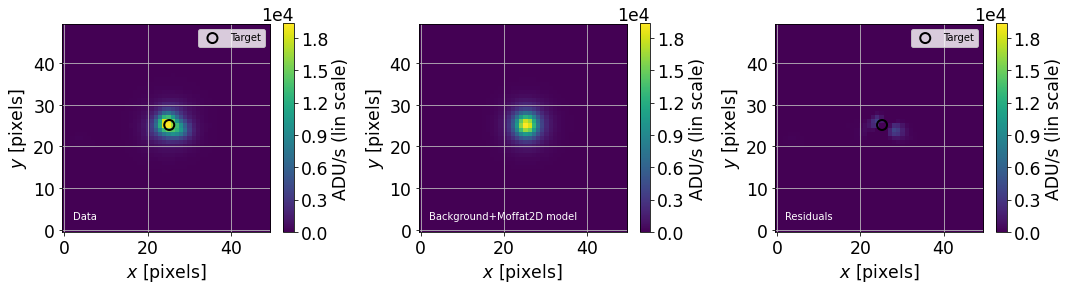

2021-10-14 23:17:25  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=0.0008680555555555555.


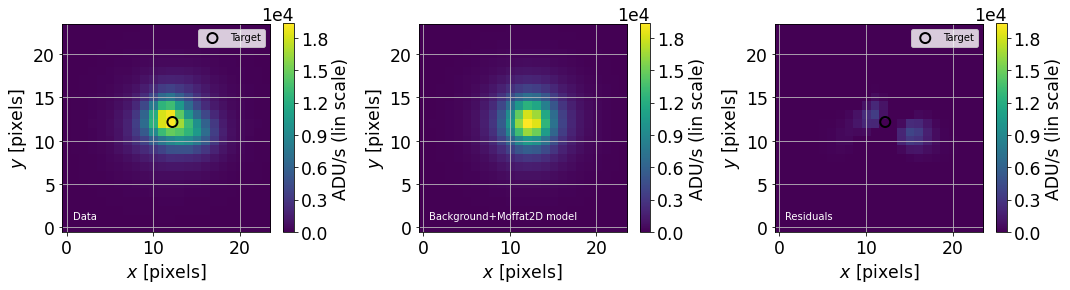

2021-10-14 23:17:26  Image      find_target          INFO   
	X,Y target position in pixels: 319.211,974.161
2021-10-14 23:17:26  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-10-14 23:17:26  TelescopeTransmission reset_lambda_range   INFO   
	With filter RG610, set parameters.LAMBDA_MIN=565.0000000000005 and parameters.LAMBDA_MAX=1089.8000000001198.
2021-10-14 23:17:26  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*20 pixels and background from 70 to 90 pixels
2021-10-14 23:17:26  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [1124:1889,884:1064] (size (765, 180))


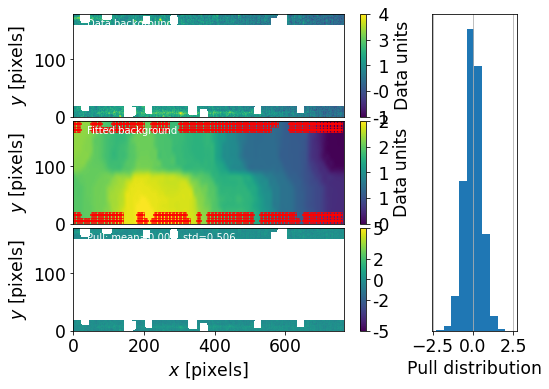

2021-10-14 23:17:29  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...


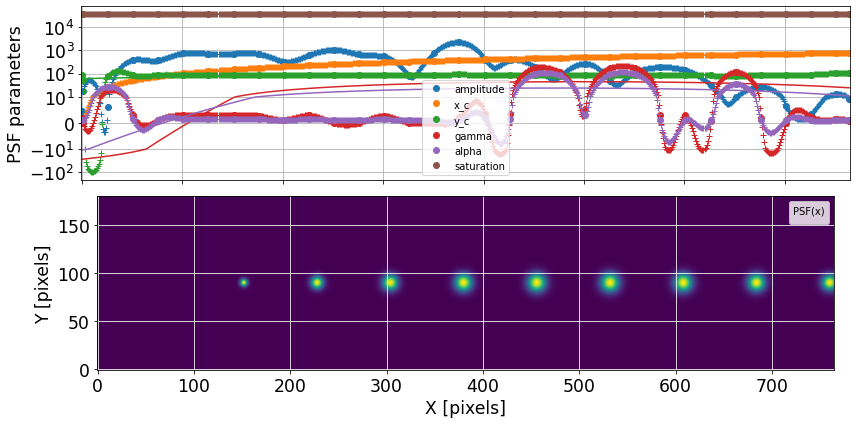

2021-10-14 23:17:32  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=5.7861e+05 initial chisq_red=18.909
		 Line search: alpha_min=2.62 iter=0 funcalls=5
	Parameter shifts: [ -2.39508544  -4.72119052  -1.66208222 -24.11980782 -47.04873194
 -39.9261422  -33.65008358 -61.4056975  -44.23460411]
	New parameters: [ -3.11676263   0.05565539  -2.28169829  -0.90149005  -7.0641274
  -5.32320742 -21.3036215  -40.65421647 -26.38810364]
	Final cost=3.497e+05 final chisq_red=11.428 computed in 0.43s
2021-10-14 23:17:32  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=3.497e+05 initial chisq_red=11.428
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.14686536  0.84825993  1.89159543  1.0759601   1.70811192  0.19011133
 21.9076691  39.08990357 25.44745578]
	New parameters: [-3.26362798  0.90391532 -0.39010285  0.17447005 -5.35601548 -5.13309609
  0.6040476  -1.5643129  -0.94064786]
	Final cost=1.8239e+05 final chisq_red

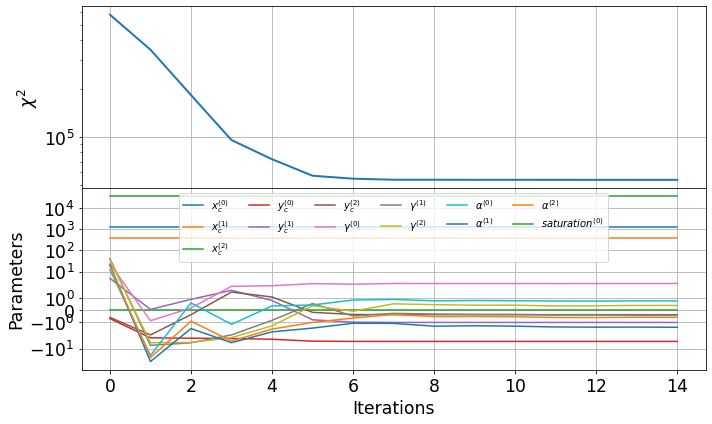

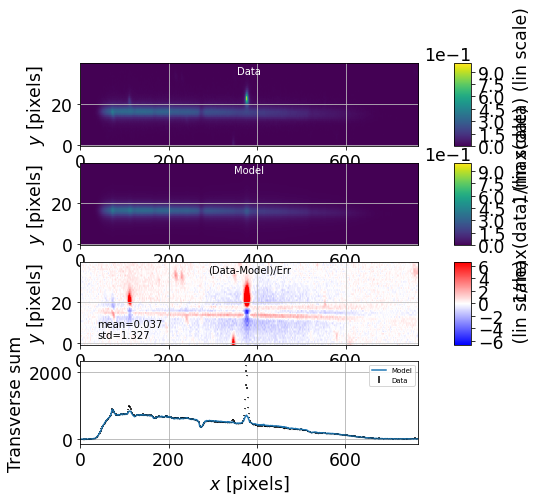

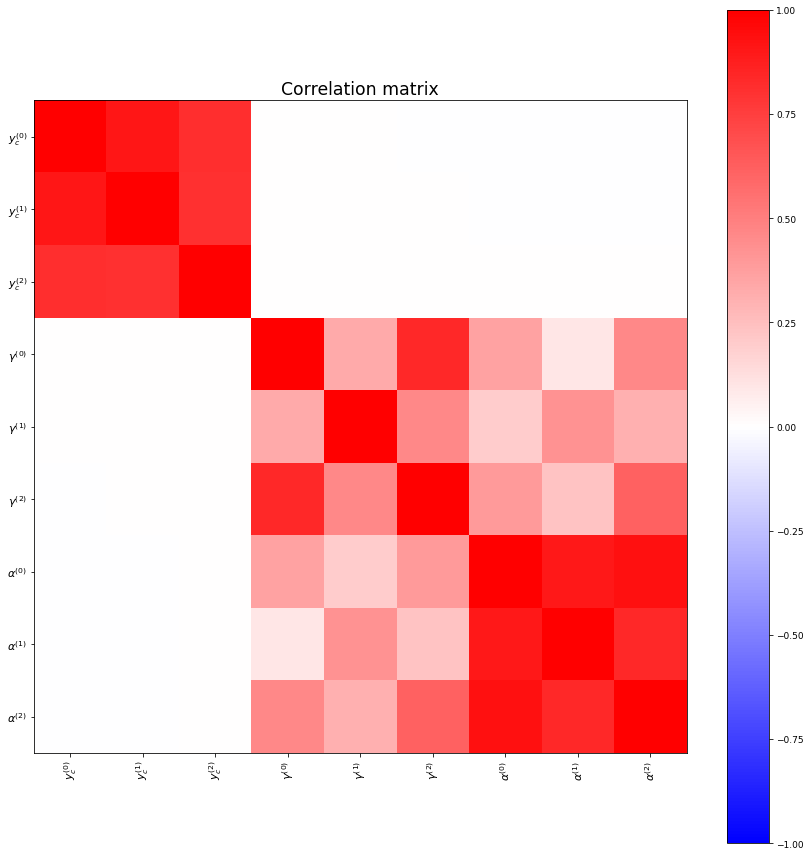

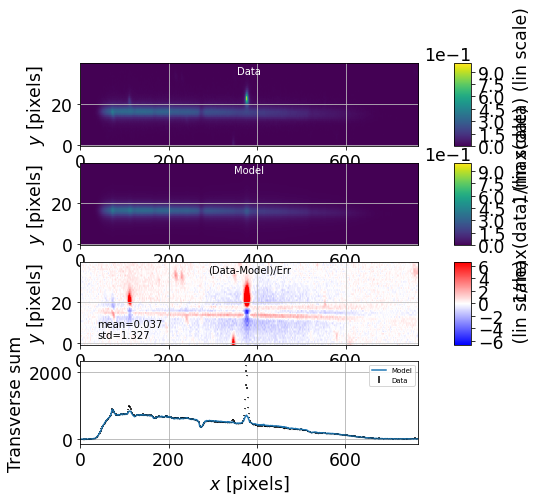

2021-10-14 23:17:44  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table before derotation:
      amplitude        x_c  ...          Dy         Dy_disp_axis
--------------------- ----- ... ------------------- ------------
0.0005208504811032321   0.0 ...  -3.952414643237674          0.0
   -0.522269002581863   1.0 ... -3.9520866118265587          0.0
    -1.12733739231246   2.0 ... -3.9517666263390936          0.0
  -0.7219213178776189   3.0 ... -3.9514546867752642          0.0
   -4.506204516013879   4.0 ... -3.9511507931350707          0.0
  -1.5073679966019173   5.0 ...  -3.950854945418527          0.0
   -7.931975785285808   6.0 ... -3.9505671436256193          0.0
   -1.396483076421404   7.0 ... -3.9502873877563474          0.0
  -3.2829636083219436   8.0 ... -3.9500156778107254          0.0
   1.0633279351278258   9.0 ...  -3.949752013788739          0.0
                  ...   ... ...                 ...          ...
   3.7574617486181423 754

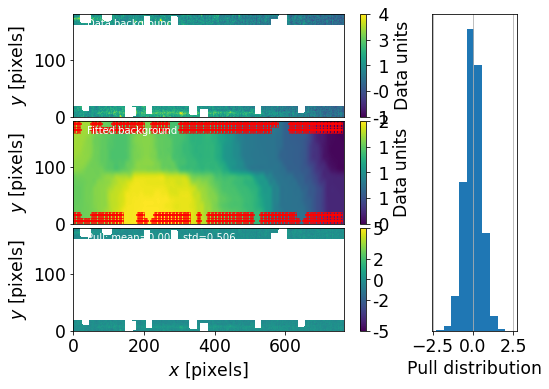

2021-10-14 23:17:45  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=1.269 ADU/s, RMS=0.783 ADU/s.
2021-10-14 23:17:45  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [1123:1888,884:1065] (size (765, 181))
	New target position in spectrogram frame: [-803.7994886192253, 90.17195317032633]


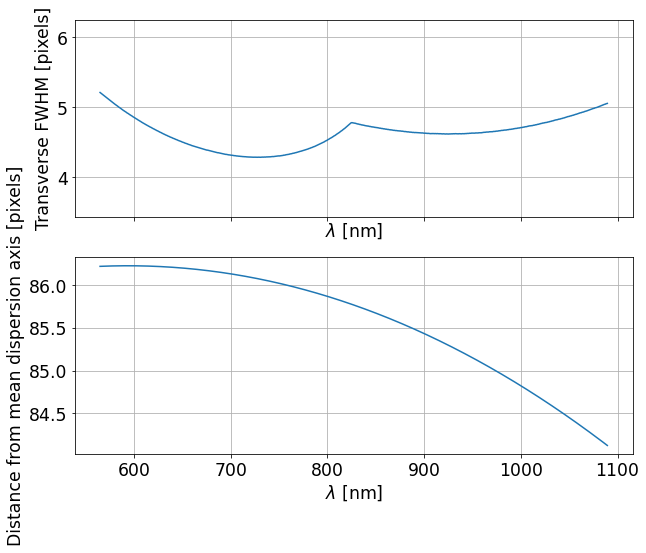

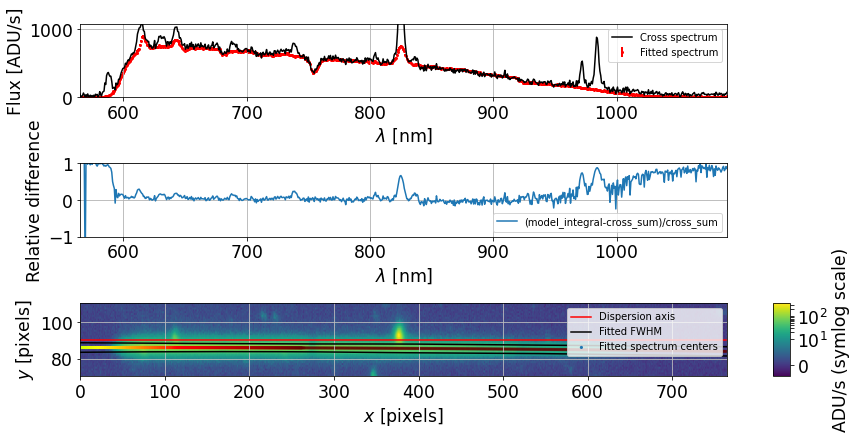

2021-10-14 23:17:48  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


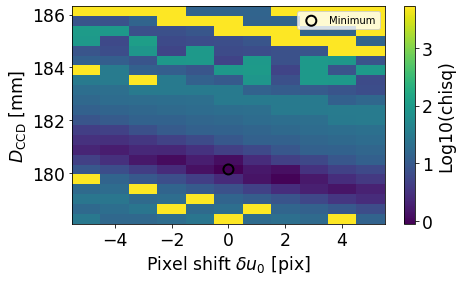

2021-10-14 23:18:00  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: 0.370pix
	D = 180.027 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -2.6 sigma shift)
2021-10-14 23:18:02  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=1.
2021-10-14 23:18:06  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=7.0496e+05 initial chisq_red=26.171
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-3.27028039  0.07470159]
	New parameters: [-1.904       0.07470159]
	Final cost=6.3951e+05 final chisq_red=23.742 computed in 3.65s
2021-10-14 23:18:25  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=6.3951e+05 initial chisq_red=23.742
		 Line search: alpha_min=0 iter=32 funcalls=36
	Parameter shifts: [-0.  0.]
	New parameters: [-1.904       0.07470159]
	Final cost=6.3951e+05 final chisq_red=23.742 computed in 18.48s
2021-10-14 23:18:25  spectractor.

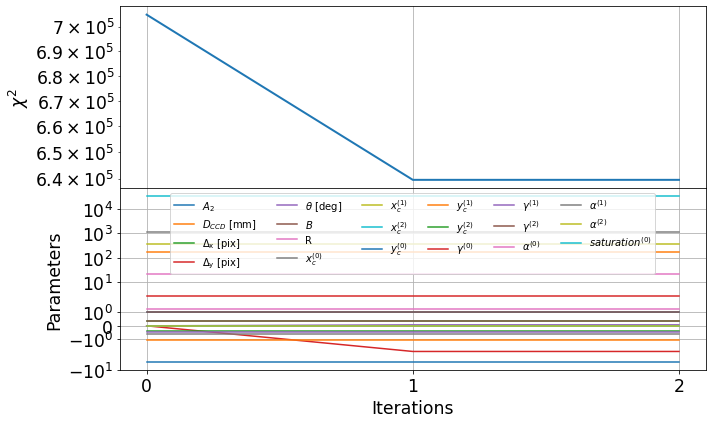

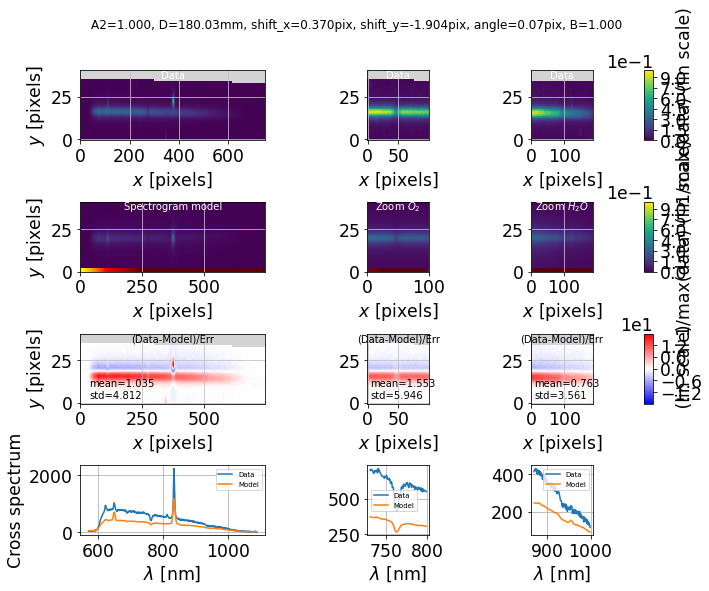

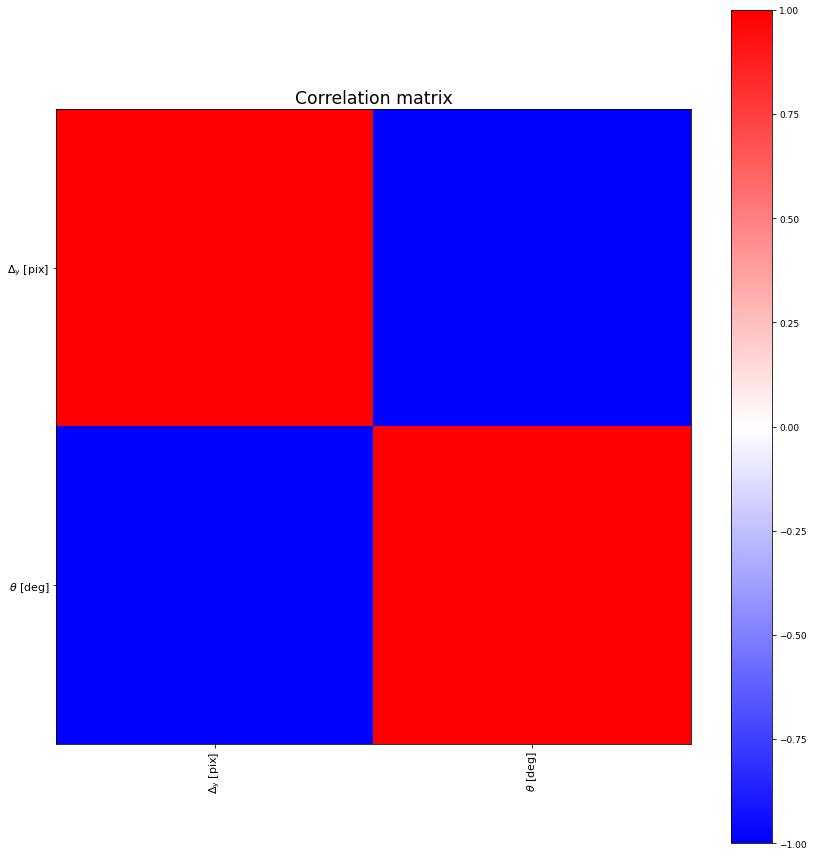

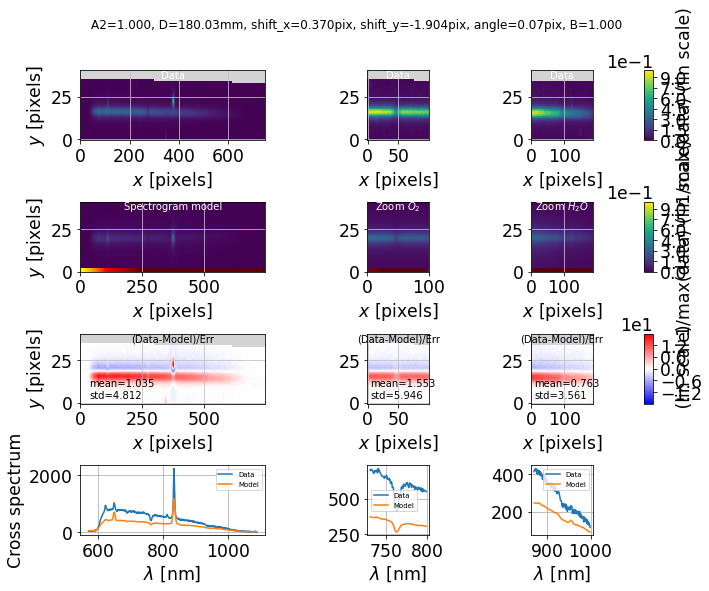

2021-10-14 23:18:32  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start guess: [ 1.00000000e+00  1.80027053e+02  3.70239265e-01 -1.90400000e+00
  7.47015888e-02  1.00000000e+00  2.20807809e+01  1.18678938e+03
  3.82000000e+02 -1.67622874e-13 -4.60829878e+00 -1.04724859e+00
 -3.91364454e-01  2.73838435e+00 -4.29273263e-01  3.88751642e-01
  1.21843785e+00 -6.00733083e-01  9.15914378e-03  3.40000000e+04]
	with ['A2', 'D_CCD [mm]', 'shift_x [pix]', 'shift_y [pix]', 'angle [deg]', 'B', 'R', 'x_c_0', 'x_c_1', 'x_c_2', 'y_c_0', 'y_c_1', 'y_c_2', 'gamma_0', 'gamma_1', 'gamma_2', 'alpha_0', 'alpha_1', 'alpha_2', 'saturation_0']
2021-10-14 23:18:57  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=6.3951e+05 initial chisq_red=23.742
		 Line search: alpha_min=0 iter=46 funcalls=50
	Parameter shifts: [-0.  0.  0. -0. -0.  0. -0. -0.]
	New parameters: [-1.904       0.07470159  2.73838435 -0.42927326  0.38875164  1.21843785
 -0.60073308  0.00915914]
	Fi

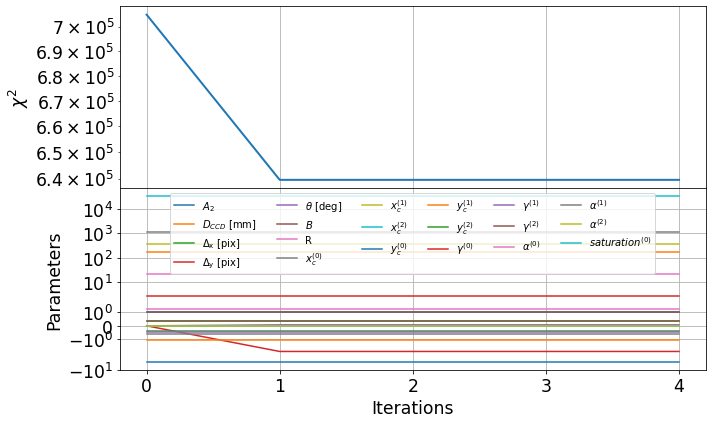

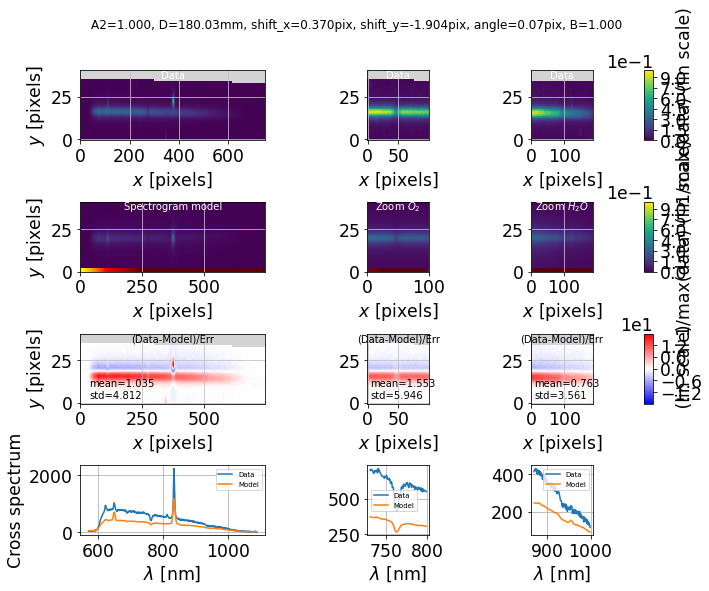

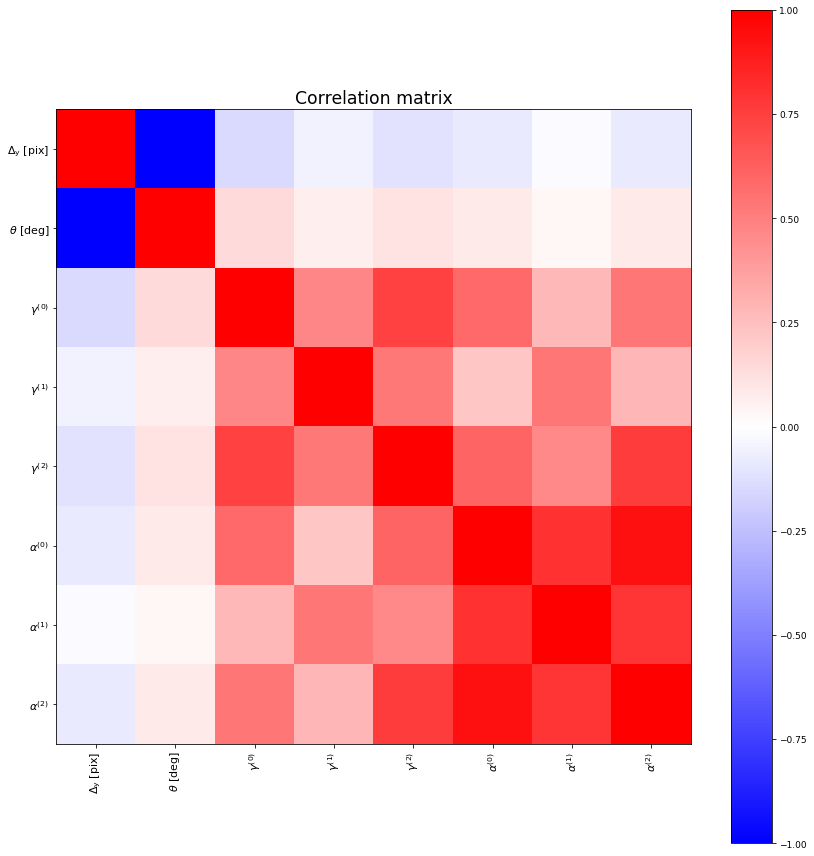

2021-10-14 23:19:03  spectractor.fit.fitter run_minimisation     DEBUG  
	Start guess: [0.]
/users/dagoret/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
2021-10-14 23:19:05  spectractor.fit.fitter run_minimisation     DEBUG  
	 final_simplex: (array([[-0.140875 ],
       [-0.1409375]]), array([3.95219619e-07, 3.95219619e-07]))
           fun: 3.952196187326147e-07
       message: 'Optimization terminated successfully.'
          nfev: 38
           nit: 19
        status: 0
       success: True
             x: array([-0.140875])
2021-10-14 23:19:05  spectractor.fit.fitter run_minimisation     DEBUG  
	Minimize: total computation time: 2.262854814529419s


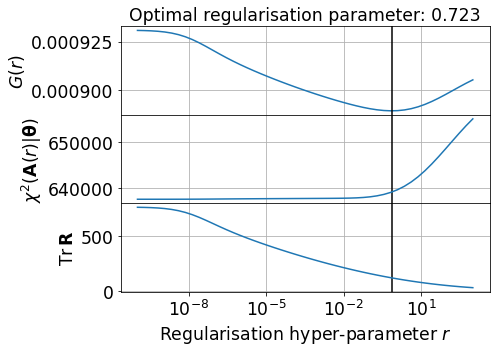

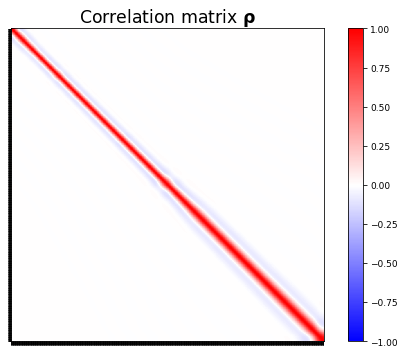

2021-10-14 23:19:17  RegFitWorkspace print_regularisation_summary INFO   
	Optimal regularisation parameter: 0.7229778634148778
	Tr(R) = 122.53755678230257
	N_params = 765
	N_data = 26936 (without mask and outliers)
2021-10-14 23:19:44  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=6.392e+05 initial chisq_red=23.731
		 Line search: alpha_min=0 iter=43 funcalls=47
	Parameter shifts: [-0.  0.  0. -0. -0.  0. -0. -0.]
	New parameters: [-1.904       0.07470159  2.73838435 -0.42927326  0.38875164  1.21843785
 -0.60073308  0.00915914]
	Final cost=6.392e+05 final chisq_red=23.731 computed in 24.16s
2021-10-14 23:19:44  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 0 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-05.
2021-10-14 23:19:44  spectractor.fit.fitter print_parameter_summary INFO   
	shift_y [pix]: -1.90 +0.05 -0.05
	angle [deg]: 0.075 +0.002 -0.002
	gamma_0: 2.

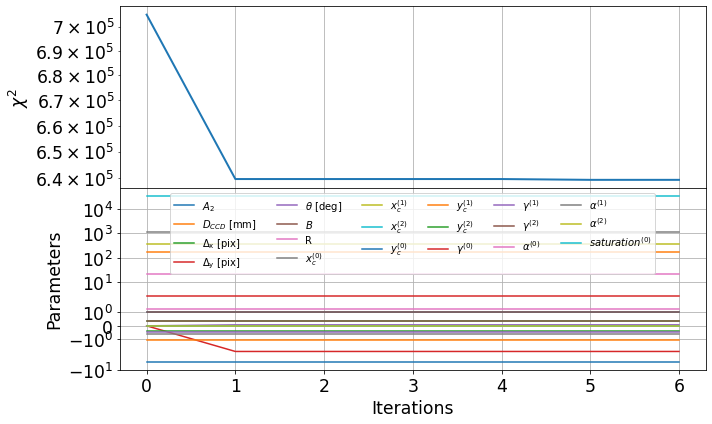

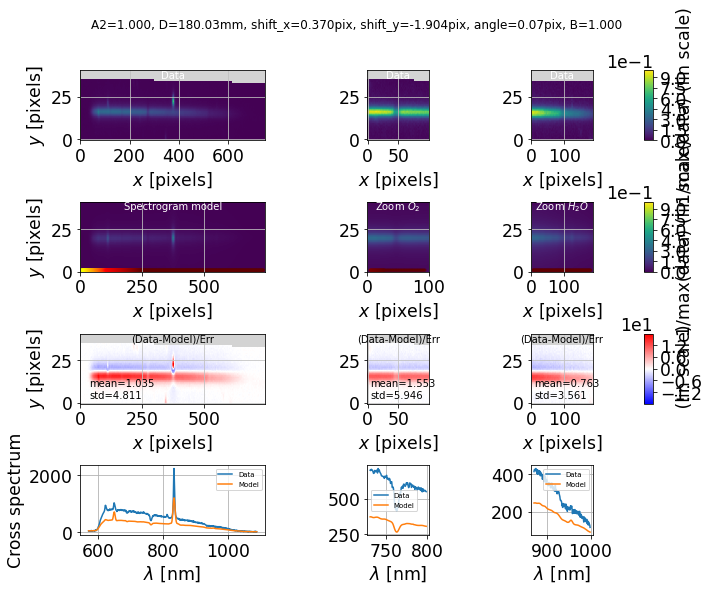

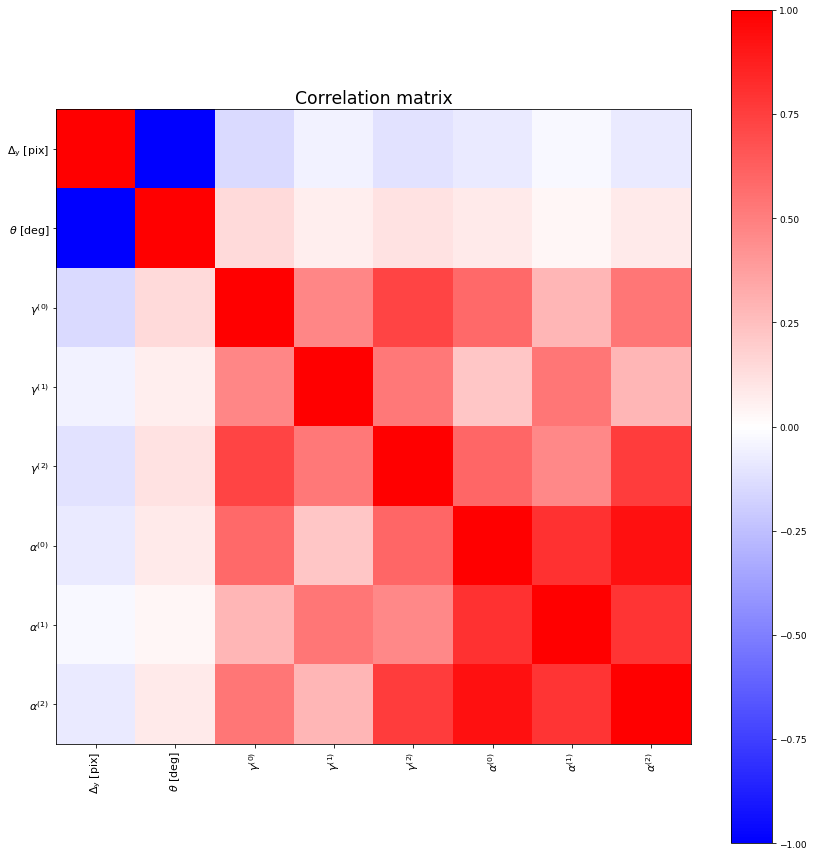

2021-10-14 23:19:48  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [11547, 11548, 11549, 11550, 11551, 11552, 11553, 11614, 11623, 11626, 11630, 12310, 12311, 12312, 12313, 12314, 12315, 12316, 12317, 12318, 12319, 12320, 12321, 12322, 12323, 12324, 12325, 12326, 12327, 12328, 12329, 12330, 12331, 12332, 12333, 12334, 12335, 12336, 12337, 12338, 12339, 12340, 12341, 12342, 12343, 12344, 12345, 12346, 12347, 12349, 12357, 12359, 12360, 12362, 12365, 12366, 12367, 12368, 12369, 12370, 12371, 12372, 12373, 12374, 12375, 12376, 12377, 12378, 12379, 12380, 12381, 12382, 12383, 12384, 12385, 12386, 12387, 12388, 12389, 12390, 12391, 12392, 12393, 12394, 12395, 12396, 12397, 12398, 12399, 12400, 12401, 12402, 12403, 12404, 12405, 12406, 12413, 12416, 12417, 12418, 12420, 12421, 12422, 12423, 12424, 12425, 12426, 12427, 12428, 12429, 12430, 12431, 12432, 12433, 12434, 12435, 12436, 12437, 12438, 12439, 12440, 12442, 12443, 12444, 12445, 13079, 17205,

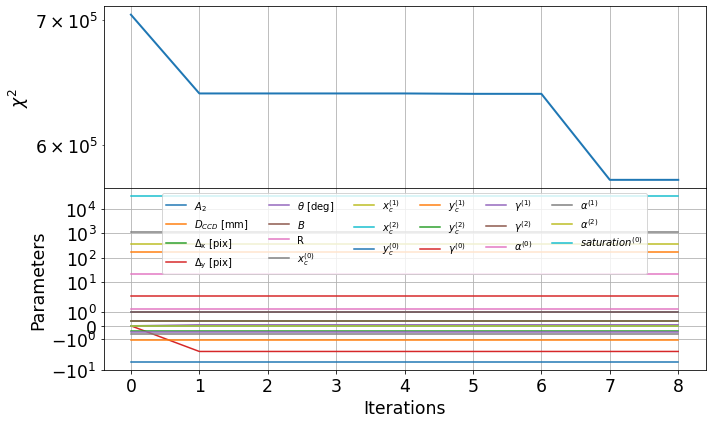

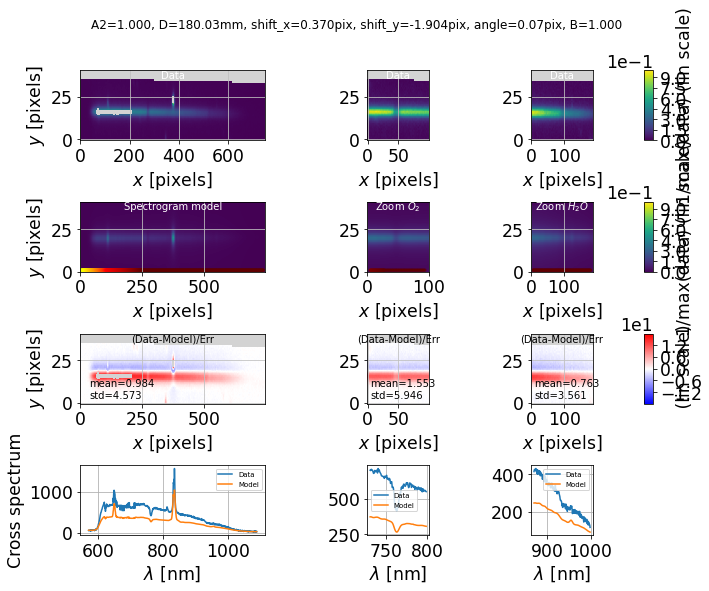

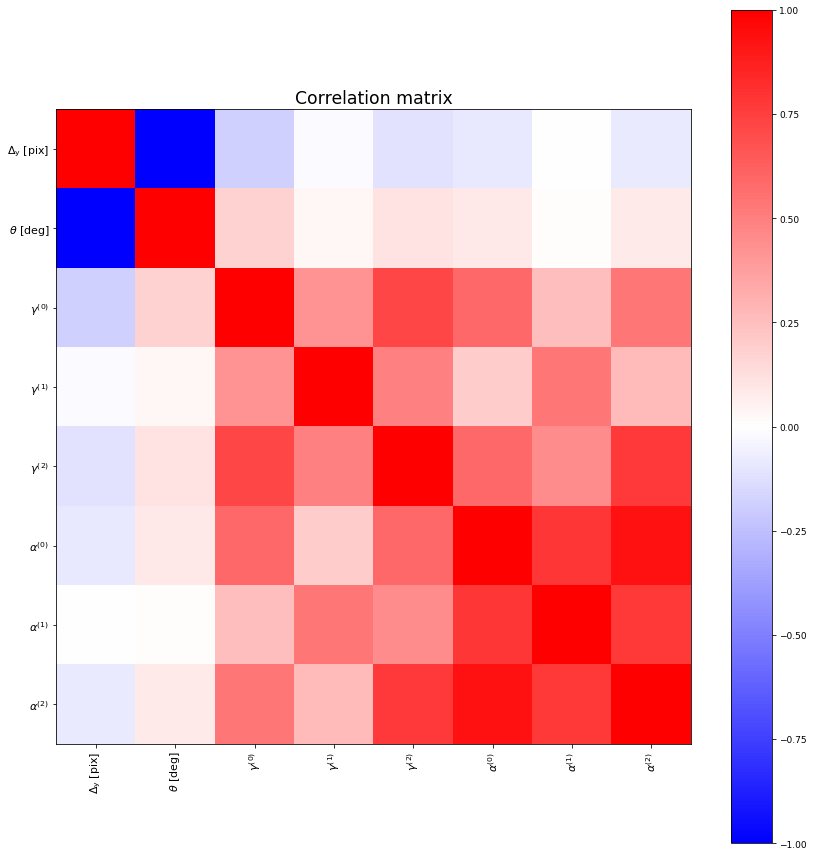

2021-10-14 23:20:15  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [11546, 11547, 11548, 11549, 11550, 11551, 11552, 11553, 11554, 11559, 11563, 11568, 11570, 11573, 11610, 11611, 11614, 11617, 11619, 11622, 11623, 11626, 11630, 11635, 11668, 12310, 12311, 12312, 12313, 12314, 12315, 12316, 12317, 12318, 12319, 12320, 12321, 12322, 12323, 12324, 12325, 12326, 12327, 12328, 12329, 12330, 12331, 12332, 12333, 12334, 12335, 12336, 12337, 12338, 12339, 12340, 12341, 12342, 12343, 12344, 12345, 12346, 12347, 12349, 12357, 12359, 12360, 12362, 12363, 12365, 12366, 12367, 12368, 12369, 12370, 12371, 12372, 12373, 12374, 12375, 12376, 12377, 12378, 12379, 12380, 12381, 12382, 12383, 12384, 12385, 12386, 12387, 12388, 12389, 12390, 12391, 12392, 12393, 12394, 12395, 12396, 12397, 12398, 12399, 12400, 12401, 12402, 12403, 12404, 12405, 12406, 12413, 12415, 12416, 12417, 12418, 12420, 12421, 12422, 12423, 12424, 12425, 12426, 12427, 12428, 12429, 12430,

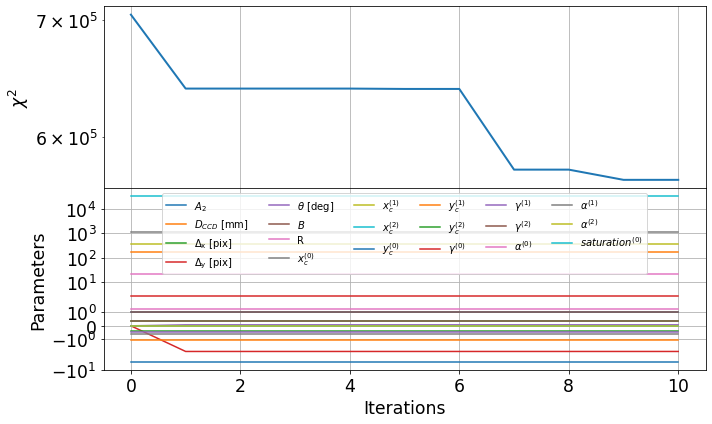

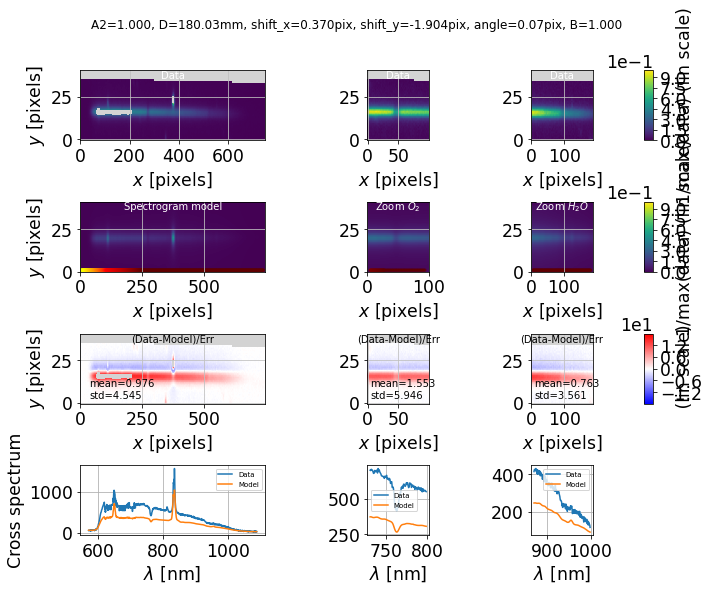

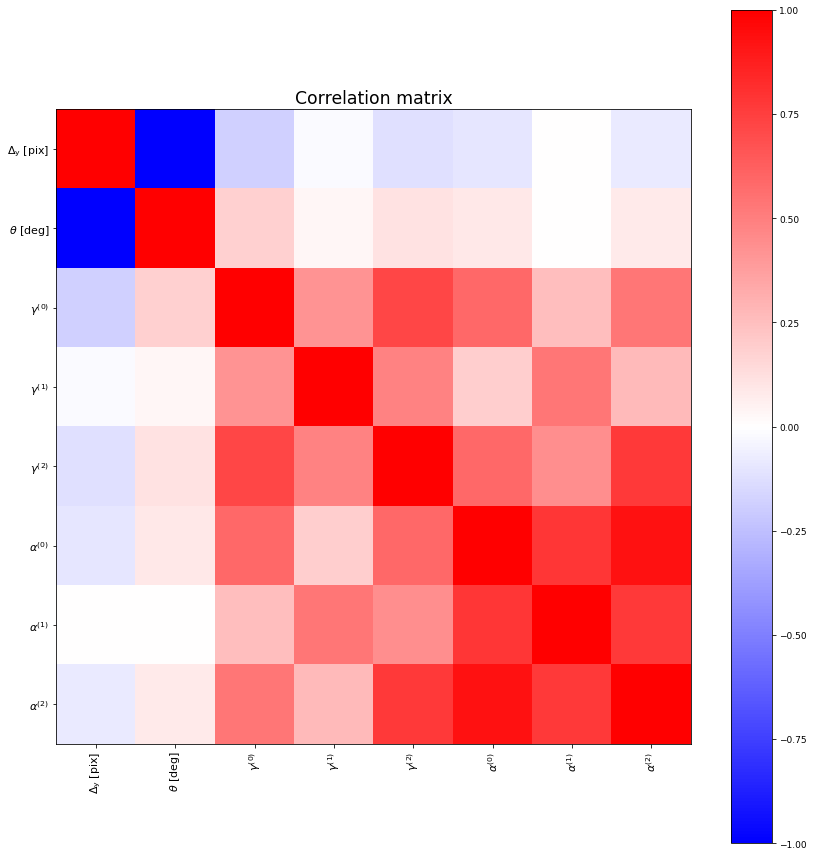

2021-10-14 23:20:41  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [11546, 11547, 11548, 11549, 11550, 11551, 11552, 11553, 11554, 11555, 11559, 11563, 11568, 11570, 11573, 11610, 11611, 11614, 11617, 11619, 11622, 11623, 11626, 11630, 11635, 11668, 12310, 12311, 12312, 12313, 12314, 12315, 12316, 12317, 12318, 12319, 12320, 12321, 12322, 12323, 12324, 12325, 12326, 12327, 12328, 12329, 12330, 12331, 12332, 12333, 12334, 12335, 12336, 12337, 12338, 12339, 12340, 12341, 12342, 12343, 12344, 12345, 12346, 12347, 12349, 12357, 12359, 12360, 12362, 12363, 12365, 12366, 12367, 12368, 12369, 12370, 12371, 12372, 12373, 12374, 12375, 12376, 12377, 12378, 12379, 12380, 12381, 12382, 12383, 12384, 12385, 12386, 12387, 12388, 12389, 12390, 12391, 12392, 12393, 12394, 12395, 12396, 12397, 12398, 12399, 12400, 12401, 12402, 12403, 12404, 12405, 12406, 12413, 12415, 12416, 12417, 12418, 12420, 12421, 12422, 12423, 12424, 12425, 12426, 12427, 12428, 12429,

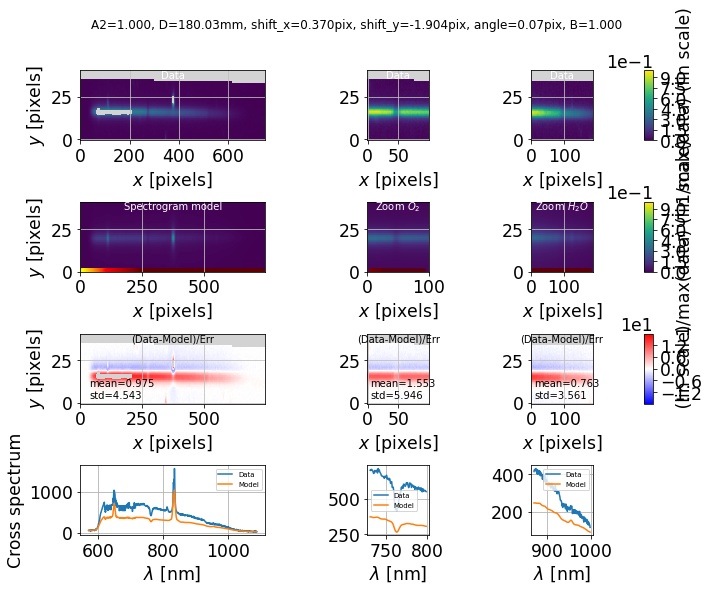

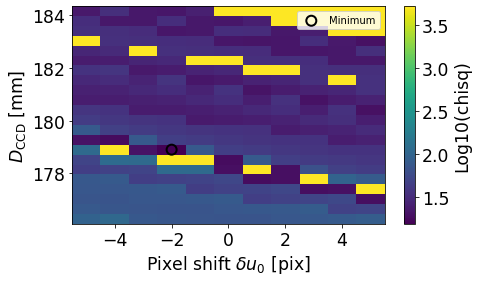

2021-10-14 23:21:03  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -1.872pix
	D = 178.902 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -4.1 sigma shift)
2021-10-14 23:21:33  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=5.6628e+05 initial chisq_red=21.023
		 Line search: alpha_min=0 iter=50 funcalls=54
	Parameter shifts: [-0.  0.  0. -0. -0.  0. -0. -0.]
	New parameters: [-1.904       0.07470159  2.73838435 -0.42927326  0.38875164  1.21843785
 -0.60073308  0.00915914]
	Final cost=5.6628e+05 final chisq_red=21.023 computed in 28.03s
2021-10-14 23:21:33  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 0 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-05.
2021-10-14 23:21:33  spectractor.fit.fitter print_parameter_summary INFO   
	shift_y [pix]: -1.90 +0.05 -0.05
	angle [deg]: 0.075 +0.003 -0.003
	gamma_0: 2.74 +0.03 -0.03
	gamma_1: -0.43 +0.06 -0.06


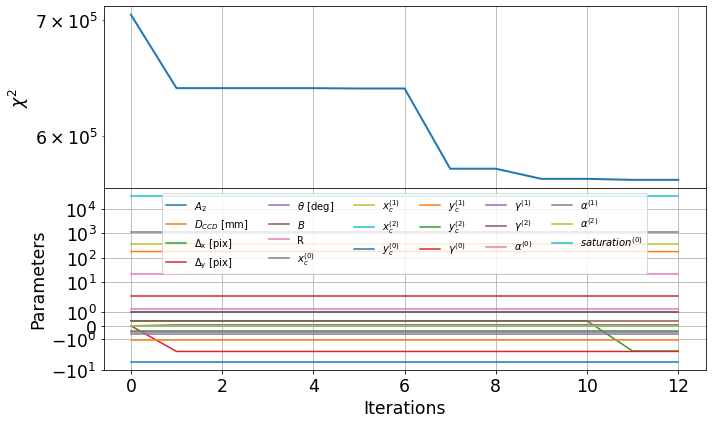

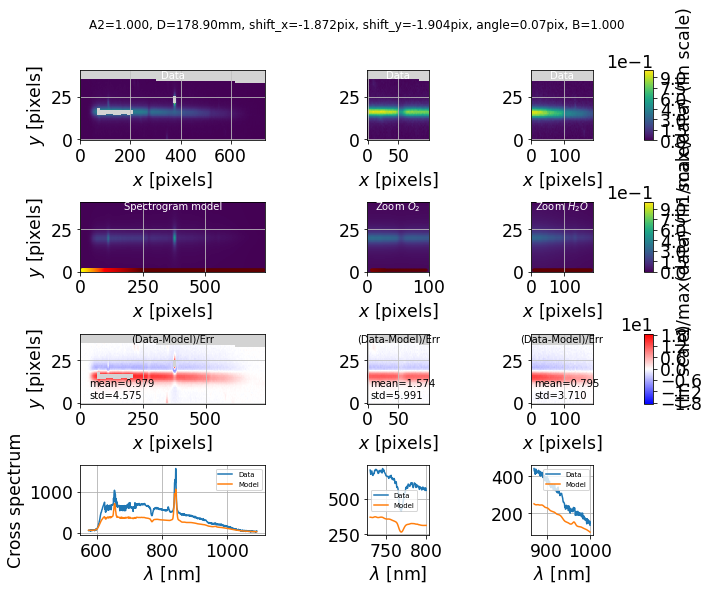

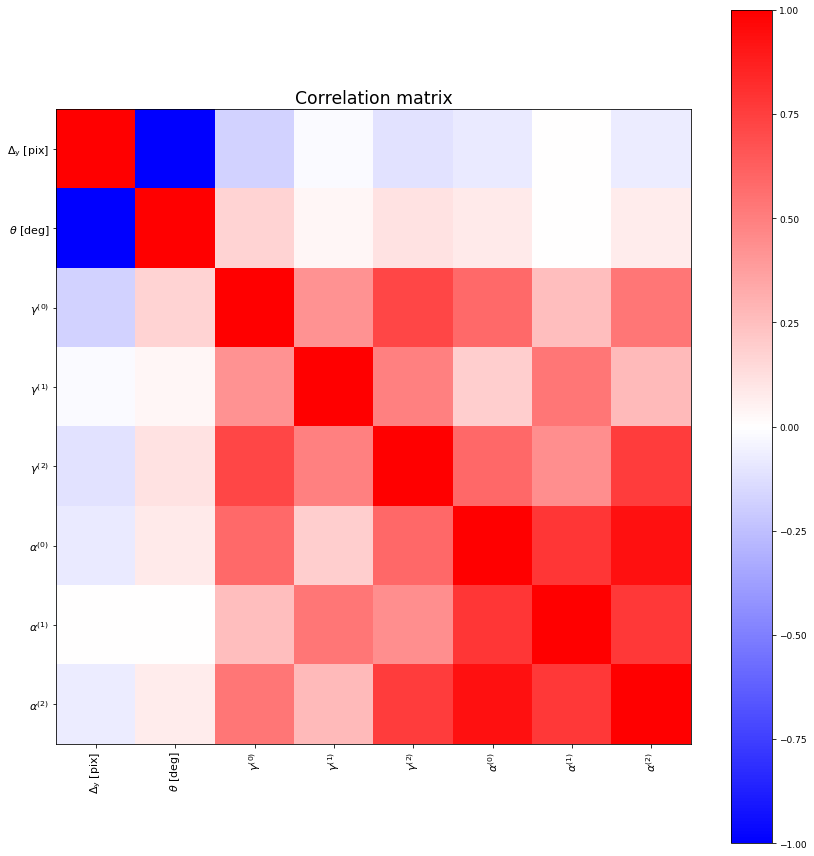

2021-10-14 23:21:36  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [11546, 11547, 11548, 11549, 11550, 11551, 11552, 11553, 11554, 11559, 11563, 11568, 11570, 11573, 11610, 11611, 11614, 11617, 11619, 11622, 11623, 11626, 11630, 11668, 12310, 12311, 12312, 12313, 12314, 12315, 12316, 12317, 12318, 12319, 12320, 12321, 12322, 12323, 12324, 12325, 12326, 12327, 12328, 12329, 12330, 12331, 12332, 12333, 12334, 12335, 12336, 12337, 12338, 12339, 12340, 12341, 12342, 12343, 12344, 12345, 12346, 12347, 12349, 12357, 12359, 12360, 12362, 12363, 12365, 12366, 12367, 12368, 12369, 12370, 12371, 12372, 12373, 12374, 12375, 12376, 12377, 12378, 12379, 12380, 12381, 12382, 12383, 12384, 12385, 12386, 12387, 12388, 12389, 12390, 12391, 12392, 12393, 12394, 12395, 12396, 12397, 12398, 12399, 12400, 12401, 12402, 12403, 12404, 12405, 12406, 12413, 12415, 12416, 12417, 12418, 12420, 12421, 12422, 12423, 12424, 12425, 12426, 12427, 12428, 12429, 12430, 12431,

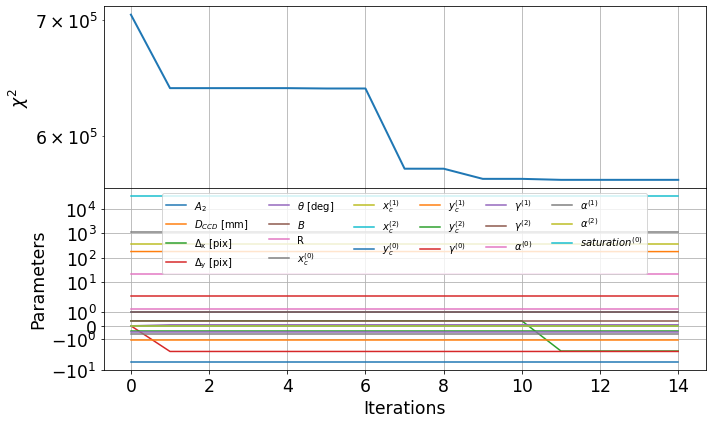

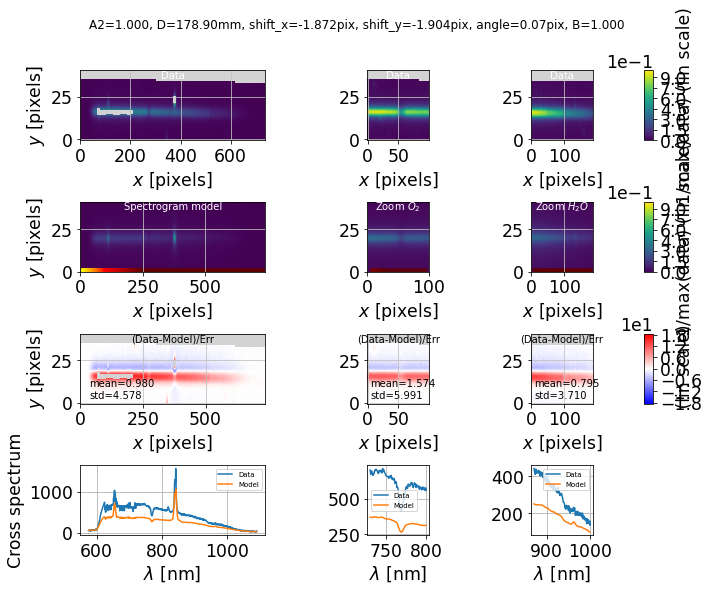

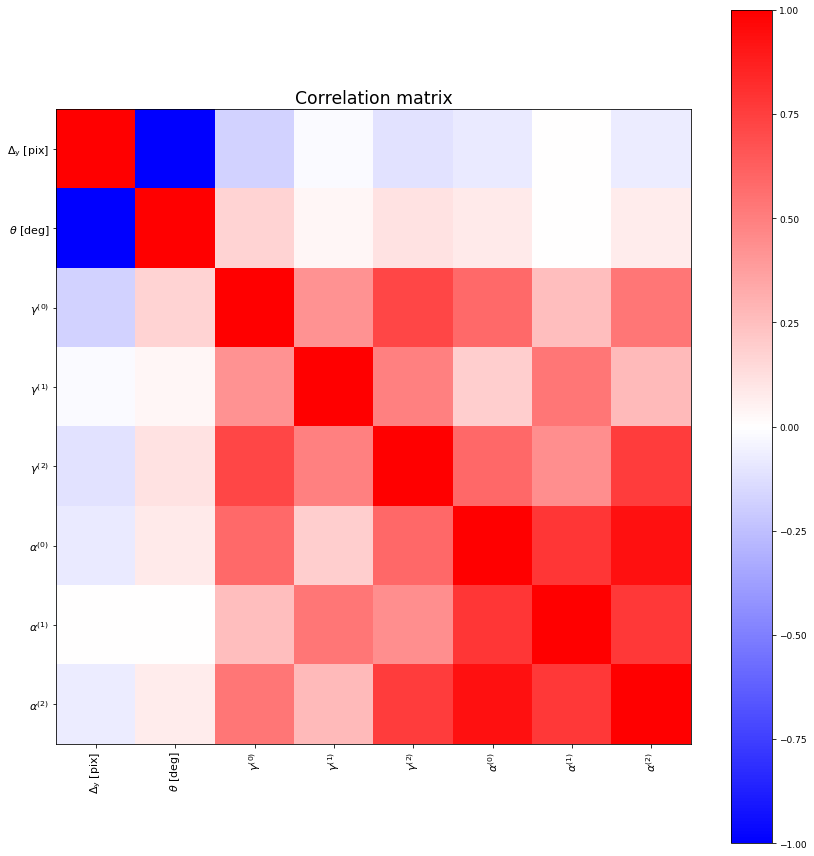

2021-10-14 23:22:11  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [11546, 11547, 11548, 11549, 11550, 11551, 11552, 11553, 11554, 11559, 11563, 11568, 11570, 11573, 11610, 11611, 11614, 11617, 11619, 11622, 11623, 11626, 11630, 11668, 12310, 12311, 12312, 12313, 12314, 12315, 12316, 12317, 12318, 12319, 12320, 12321, 12322, 12323, 12324, 12325, 12326, 12327, 12328, 12329, 12330, 12331, 12332, 12333, 12334, 12335, 12336, 12337, 12338, 12339, 12340, 12341, 12342, 12343, 12344, 12345, 12346, 12347, 12349, 12357, 12359, 12360, 12362, 12363, 12365, 12366, 12367, 12368, 12369, 12370, 12371, 12372, 12373, 12374, 12375, 12376, 12377, 12378, 12379, 12380, 12381, 12382, 12383, 12384, 12385, 12386, 12387, 12388, 12389, 12390, 12391, 12392, 12393, 12394, 12395, 12396, 12397, 12398, 12399, 12400, 12401, 12402, 12403, 12404, 12405, 12406, 12413, 12415, 12416, 12417, 12418, 12420, 12421, 12422, 12423, 12424, 12425, 12426, 12427, 12428, 12429, 12430, 12431,

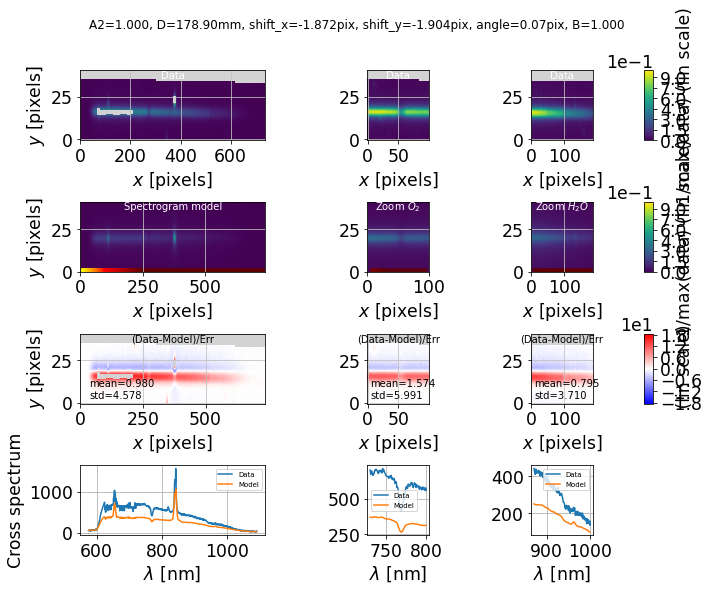

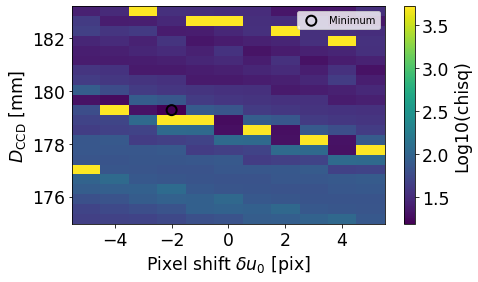

2021-10-14 23:22:32  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -2.000pix
	D = 179.279 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -3.6 sigma shift)
2021-10-14 23:22:32  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.
2021-10-14 23:22:32  astroquery _showwarning         WARNING VerifyWarning: Card is too long, comment will be truncated.
2021-10-14 23:22:32  Spectrum   save_spectrum        INFO   
	Spectrum saved in ./outputs_process_holo_scan/holo4_003_RG610_HD160617_20210707_000239_quickLookExp_spectrum.fits
2021-10-14 23:22:32  Spectrum   save_spectrogram     INFO   
	Spectrogram saved in ./outputs_process_holo_scan/holo4_003_RG610_HD160617_20210707_000239_quickLookExp_spectrogram.fits


 Line Tabulated  Detected   Shift    ...   Chisq   Eqwidth_mod Eqwidth_data
          nm        nm        nm     ...  reduced       nm          nm     
----- --------- --------- ---------- ... --------- ----------- ------------
          760.3 756.80396 -3.4960234 ... 5.4940767  0.74319375    3.1133556
$O_2$     763.1     766.6        3.5 ... 5.4940767   2.9595153    1.0564035


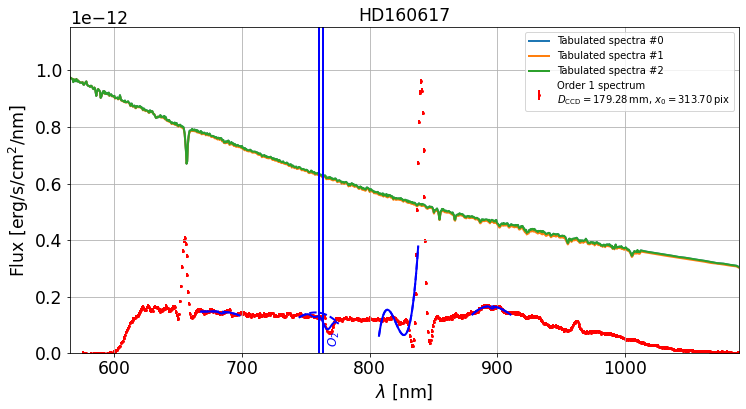

In [136]:
spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)


# Backup output

In [137]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_RG610_HD160617_20210707_000239_quickLookExp/basespec/holo4_003_RG610_HD160617_20210707_000239_quickLookExp_table.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_RG610_HD160617_20210707_000239_quickLookExp/basespec/holo4_003_RG610_HD160617_20210707_000239_quickLookExp_spectrum.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_RG610_HD160617_20210707_000239_quickLookExp/basespec/holo4_003_RG610_HD160617_20210707_000239_quickLookExp_spectrogram.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_RG610_HD160617_20210707_000239_quickLookExp/basespec/holo4_003_RG610_HD160617_20210707_000239_quickLookExp_lines.csv']

In [138]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_RG610_HD160617_20210707_000239_quickLookExp/plots/fit_chromatic_psf_best_fit_noprior.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_RG610_HD160617_20210707_000239_quickLookExp/plots/rotated_image.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_RG610_HD160617_20210707_000239_quickLookExp/plots/fwhm.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_RG610_HD160617_20210707_000239_quickLookExp/plots/order0_centroid_fit.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_RG610_HD160617_20210707_000239_quickLookExp/plots/HD160617_spectrum.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_RG610_HD160617_20210707_000239_quickLookExp/plots/regularisation.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/